In [2]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.stats as sts
import polytope as pc
import math
import pypoman

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.polytope import compute_polytope_volume, find_max_distance_to_polytope
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

In [3]:
class WangInterval(ConfidenceInterval):
    def __init__(self, tmg, n_points=1000, method='bbox', max_confidence=0.999):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)

    def __call__(self):
        if self.mode == Mode.CHANNEL:
            raise NotImplementedError("This interval works only for state tomography")
        EPS = 1e-15
        dim = 2 ** self.tmg.state.n_qubits

        frequencies = np.clip(self.tmg.raw_results / self.tmg.n_measurements[:, None], EPS, 1 - EPS)

        povm_matrix = (np.reshape(self.tmg.povm_matrix * self.tmg.n_measurements[:, None, None]
                                  / np.sum(self.tmg.n_measurements),
                                  (-1, self.tmg.povm_matrix.shape[-1]))
                       * self.tmg.povm_matrix.shape[0])
        A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
        max_delta = self._count_delta(self.max_confidence, frequencies, self.tmg.n_measurements)
        deltas = np.linspace(0, max_delta, self.n_points)
        dist_dummy = []
        for delta in deltas:
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - povm_matrix[:, 0]
            x = linprog(self.tmg.state.bloch[1:], A, b).x
            dist_dummy.append((dim-1)/dim - np.dot(x, self.tmg.state.bloch[1:]) * dim)
        
        CLs_dummy = []
        for delta in deltas:
            CLs_dummy.append(self._count_confidence(delta, frequencies, self.tmg.n_measurements))
        cl_to_dist = interp1d(CLs_dummy, dist_dummy)
        CLs = np.linspace(1e-3, self.max_confidence, self.n_points)
        dist = cl_to_dist(CLs)
        return dist, CLs
    
    @staticmethod
    def _count_confidence(delta, frequencies, n_measurements):
        EPS = 1e-15
        freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
        KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                         + (1 - frequencies) * np.log(
                    (1 - frequencies) / (1 - freq_plus_delta)))
        KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
        epsilons = np.exp(-n_measurements[:, None] * KL_divergence)
        epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
        return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))
    
    @staticmethod
    def _count_delta(confidence_threshold, frequencies, n_measurements):
        left = 1e-10
        right = 1
        while right - left > 1e-10:
            delta = (left + right) / 2
            confidence = WangInterval._count_confidence(delta, frequencies, n_measurements)
            if confidence < confidence_threshold:
                left = delta
            else:
                right = delta
        return delta

### f(n qubits)

In [3]:
conf_levels = [0.1, 0.25, 0.5, 0.75]
n_qubits_list = range(1, 4)
freq_list_qubits = defaultdict(list)
for i in tqdm(n_qubits_list):
    state = qp.qobj.GHZ(i)
    n_measurements = 100000
    dim = 2 ** state.n_qubits
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements)
    state_hat = tmg.point_estimate()
    EPS = 1e-15

    povm_matrix = (np.reshape(tmg.povm_matrix * tmg.n_measurements[:, None, None]
                              / np.sum(tmg.n_measurements),
                              (-1, tmg.povm_matrix.shape[-1]))
                   * tmg.povm_matrix.shape[0])
    A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
    polytope_prod = A @ state.bloch[1:]

    n_trials = 2000
    results = np.zeros(len(conf_levels))
    for _ in range(n_trials):
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements)
        frequencies = np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
        for i, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.n_measurements)
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - povm_matrix[:, 0]
            if np.min(b - polytope_prod) > -EPS:
                results[i] += 1
    results /= n_trials
    for i, cl in enumerate(conf_levels):
        freq_list_qubits[cl].append(results[i])

  0%|          | 0/3 [00:00<?, ?it/s]

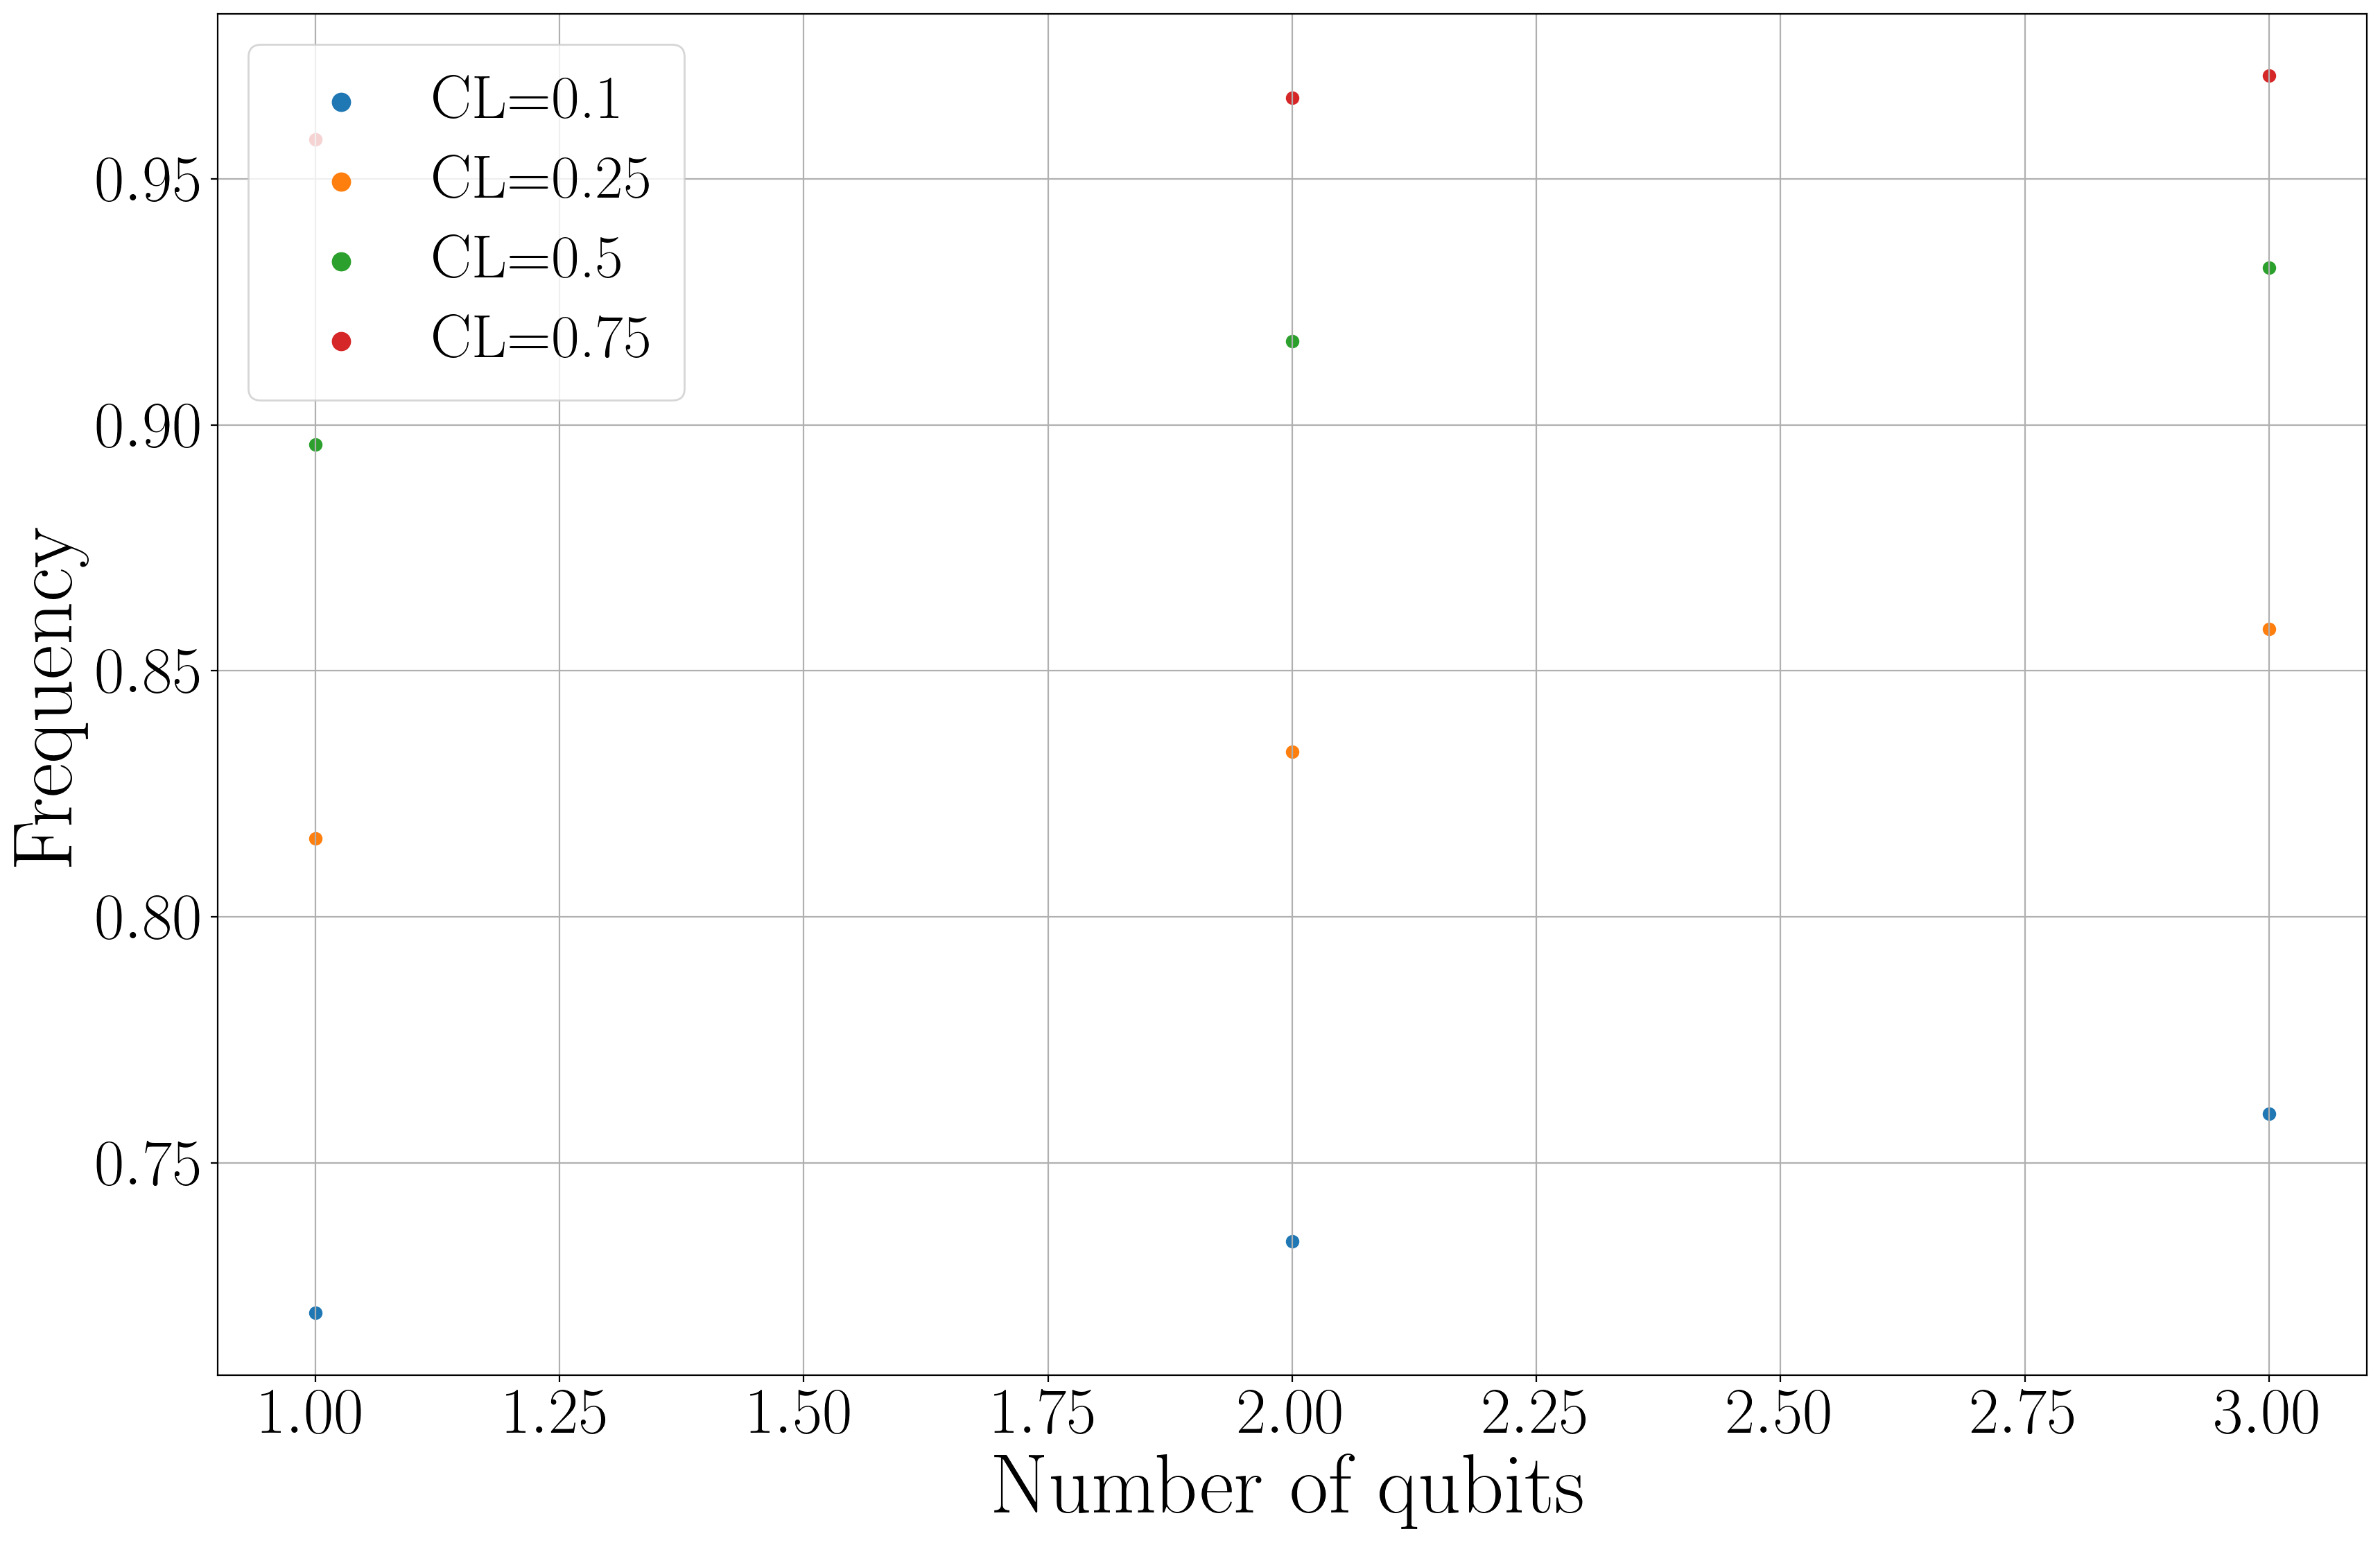

In [4]:
conf_levels = [0.1, 0.25, 0.5, 0.75]
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Number of qubits')
plt.ylabel('Frequency')
plt.grid()
for cl in conf_levels:
    plt.scatter(n_qubits_list, freq_list_qubits[cl], label=f'CL={cl}')
plt.legend()

### f(epsilon) кубиты

In [65]:
conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
n_qubits_list = range(1, 6)
results = np.zeros((len(n_qubits_list), len(conf_levels)))
n_trials = 2000
for i in tqdm(n_qubits_list):
    state = qp.qobj.GHZ(i)
    n_measurements = 100000
    dim = 2 ** state.n_qubits
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements)
    state_hat = tmg.point_estimate()
    EPS = 1e-15

    povm_matrix = (np.reshape(tmg.povm_matrix * tmg.n_measurements[:, None, None]
                              / np.sum(tmg.n_measurements),
                              (-1, tmg.povm_matrix.shape[-1]))
                   * tmg.povm_matrix.shape[0])
    A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
    polytope_prod = A @ state.bloch[1:]
    
    for _ in range(n_trials):
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements)
        frequencies = np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
        for j, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.n_measurements)
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - povm_matrix[:, 0]
            if np.min(b - polytope_prod) > -EPS:
                results[i-1, j] += 1
results /= n_trials

  0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
obj = {'cl': conf_levels, 'results': results}
with open('../results/polytope/states_qubits.pkl', 'wb') as file:
    pickle.dump(obj, file)

In [71]:
with open('../results/polytope/states_qubits.pkl', 'rb') as file:
    obj = pickle.load(file)
results = obj['results']

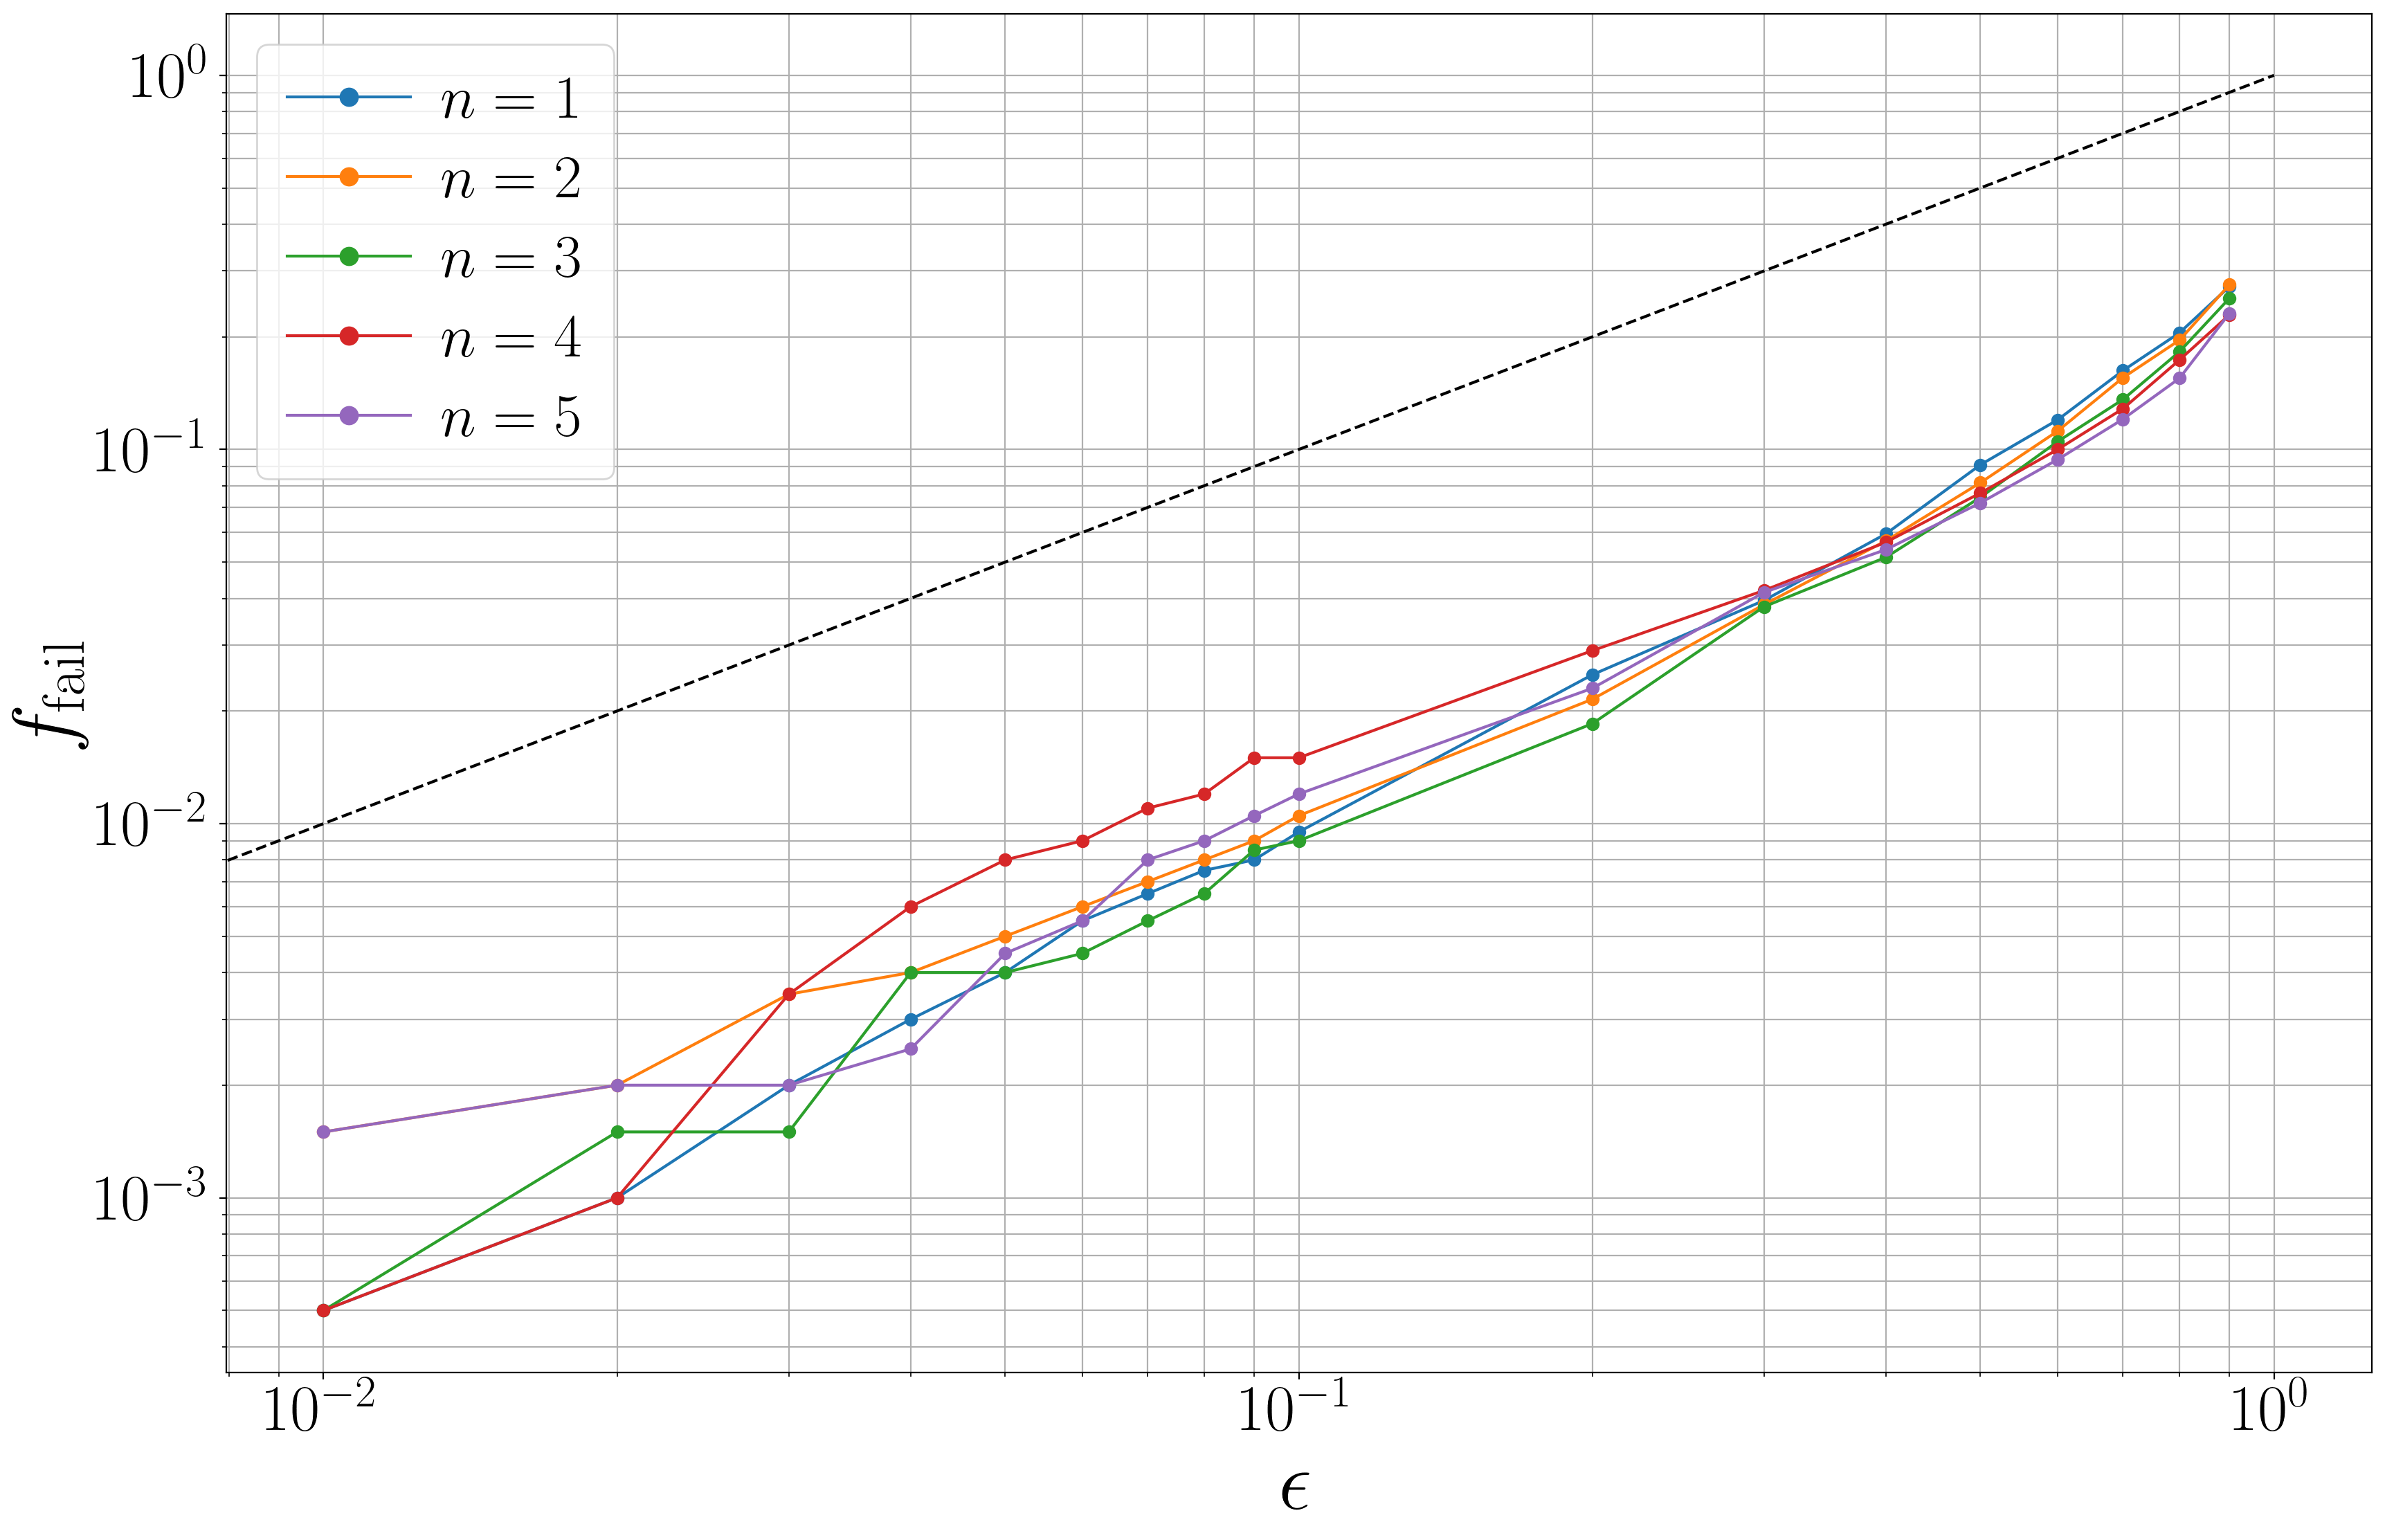

In [72]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for n, results_for_qubit in enumerate(results):
    plt.plot(1 - conf_levels, 1 - results_for_qubit, '-o', label=f'$n={n+1}$')
plt.legend()
plt.savefig('../imgs/polytope/states_qubits.png')

### f(epsilon) измерения

In [43]:
conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
n_meas_list = [int(n) for n in np.logspace(2, 7, 6)]
results = np.zeros((len(n_meas_list), len(conf_levels)))
for i, n_measurements in tqdm(enumerate(n_meas_list)):
    state = qp.qobj.GHZ(1)
    dim = 2 ** state.n_qubits
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements)
    state_hat = tmg.point_estimate()
    EPS = 1e-15

    povm_matrix = (np.reshape(tmg.povm_matrix * tmg.n_measurements[:, None, None]
                              / np.sum(tmg.n_measurements),
                              (-1, tmg.povm_matrix.shape[-1]))
                   * tmg.povm_matrix.shape[0])
    A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
    polytope_prod = A @ state.bloch[1:]

    n_trials = 2000
    
    for _ in range(n_trials):
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements)
        frequencies = np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
        for j, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.n_measurements)
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - povm_matrix[:, 0]
            if np.min(b - polytope_prod) > -EPS:
                results[i, j] += 1
results /= n_trials

0it [00:00, ?it/s]

In [56]:
obj = {'cl': conf_levels, 'results': results}
with open('../results/polytope/states_meas.pkl', 'wb') as file:
    pickle.dump(obj, file)

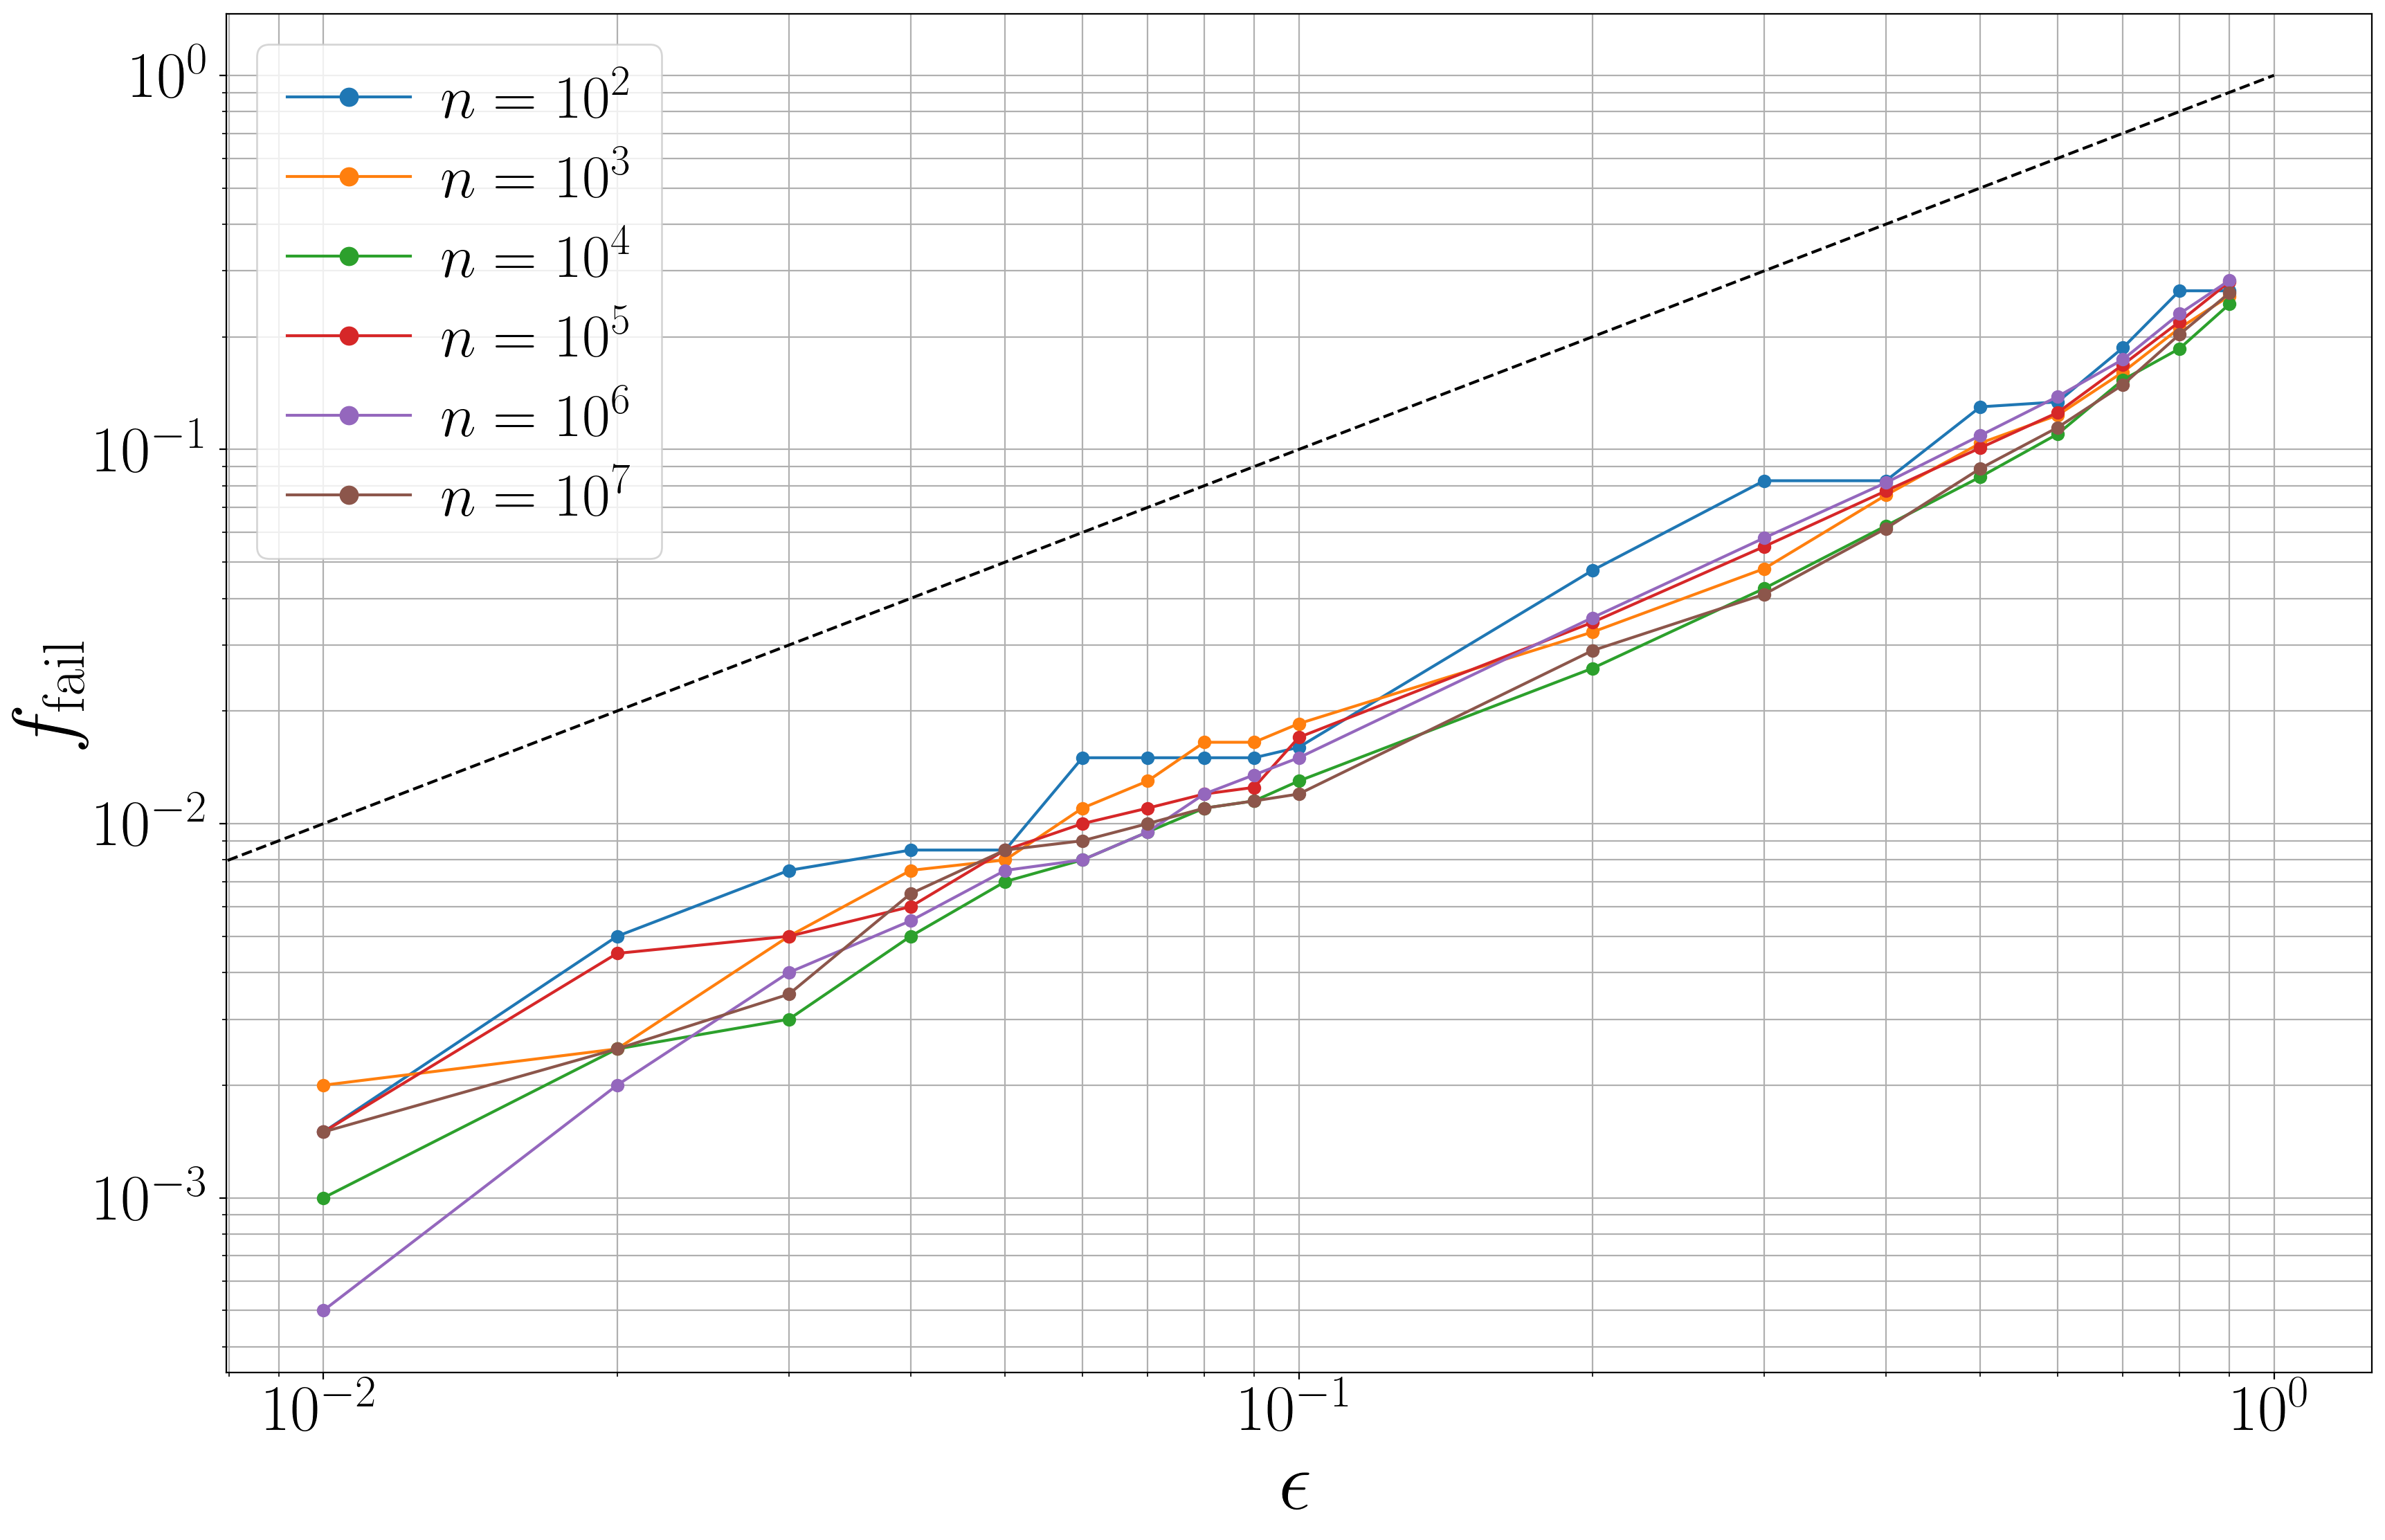

In [64]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for n, row in enumerate(results):
    plt.plot(1 - conf_levels, 1 - row, '-o', label=f'$n=10^{n+2}$')
plt.legend()
plt.savefig('../imgs/polytope/states_meas.png')

### f(epsilon) кубиты процесс

In [ ]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
conf_levels = np.arange(0.9, 1, 0.01)
n_qubits_list = range(1, 4)
results = np.zeros((len(n_qubits_list), len(conf_levels)))
n_trials = 10000
for i in range(1, 4):
    channel = qp.channel.depolarizing(p=0.1, n_qubits=i)
    n_measurements = 100000
    dim = 4 ** channel.n_qubits
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    EPS = 1e-15

    povm_matrix = tmg.tomographs[0].povm_matrix
    n_measurements = tmg.tomographs[0].n_measurements

    eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                              (-1, povm_matrix.shape[-1])) 
                   * povm_matrix.shape[0])
    Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
    pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
    pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                   pi_matrix.shape[2] * pi_matrix.shape[3]))
    A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
    polytope_prod = A @ channel.choi.bloch[dim:]
    
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        frequencies = np.asarray([
            np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
            for ptmg in tmg.tomographs
        ])
        for j, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.tomographs[0].n_measurements)
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                 - pi_matrix[:, 0] * 2 ** tmg.channel.n_qubits)
            if np.min(b - polytope_prod) > -EPS:
                results[i-1, j] += 1
results /= n_trials

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
with open('../results/polytope/processes_qubits.pkl', 'rb') as file:
    obj = pickle.load(file)
new_results = obj['results']
new_results[:, -10:] = results

In [68]:
obj = {'cl': conf_levels, 'results': results}
with open('../results/polytope/processes_qubits.pkl', 'wb') as file:
    pickle.dump(obj, file)

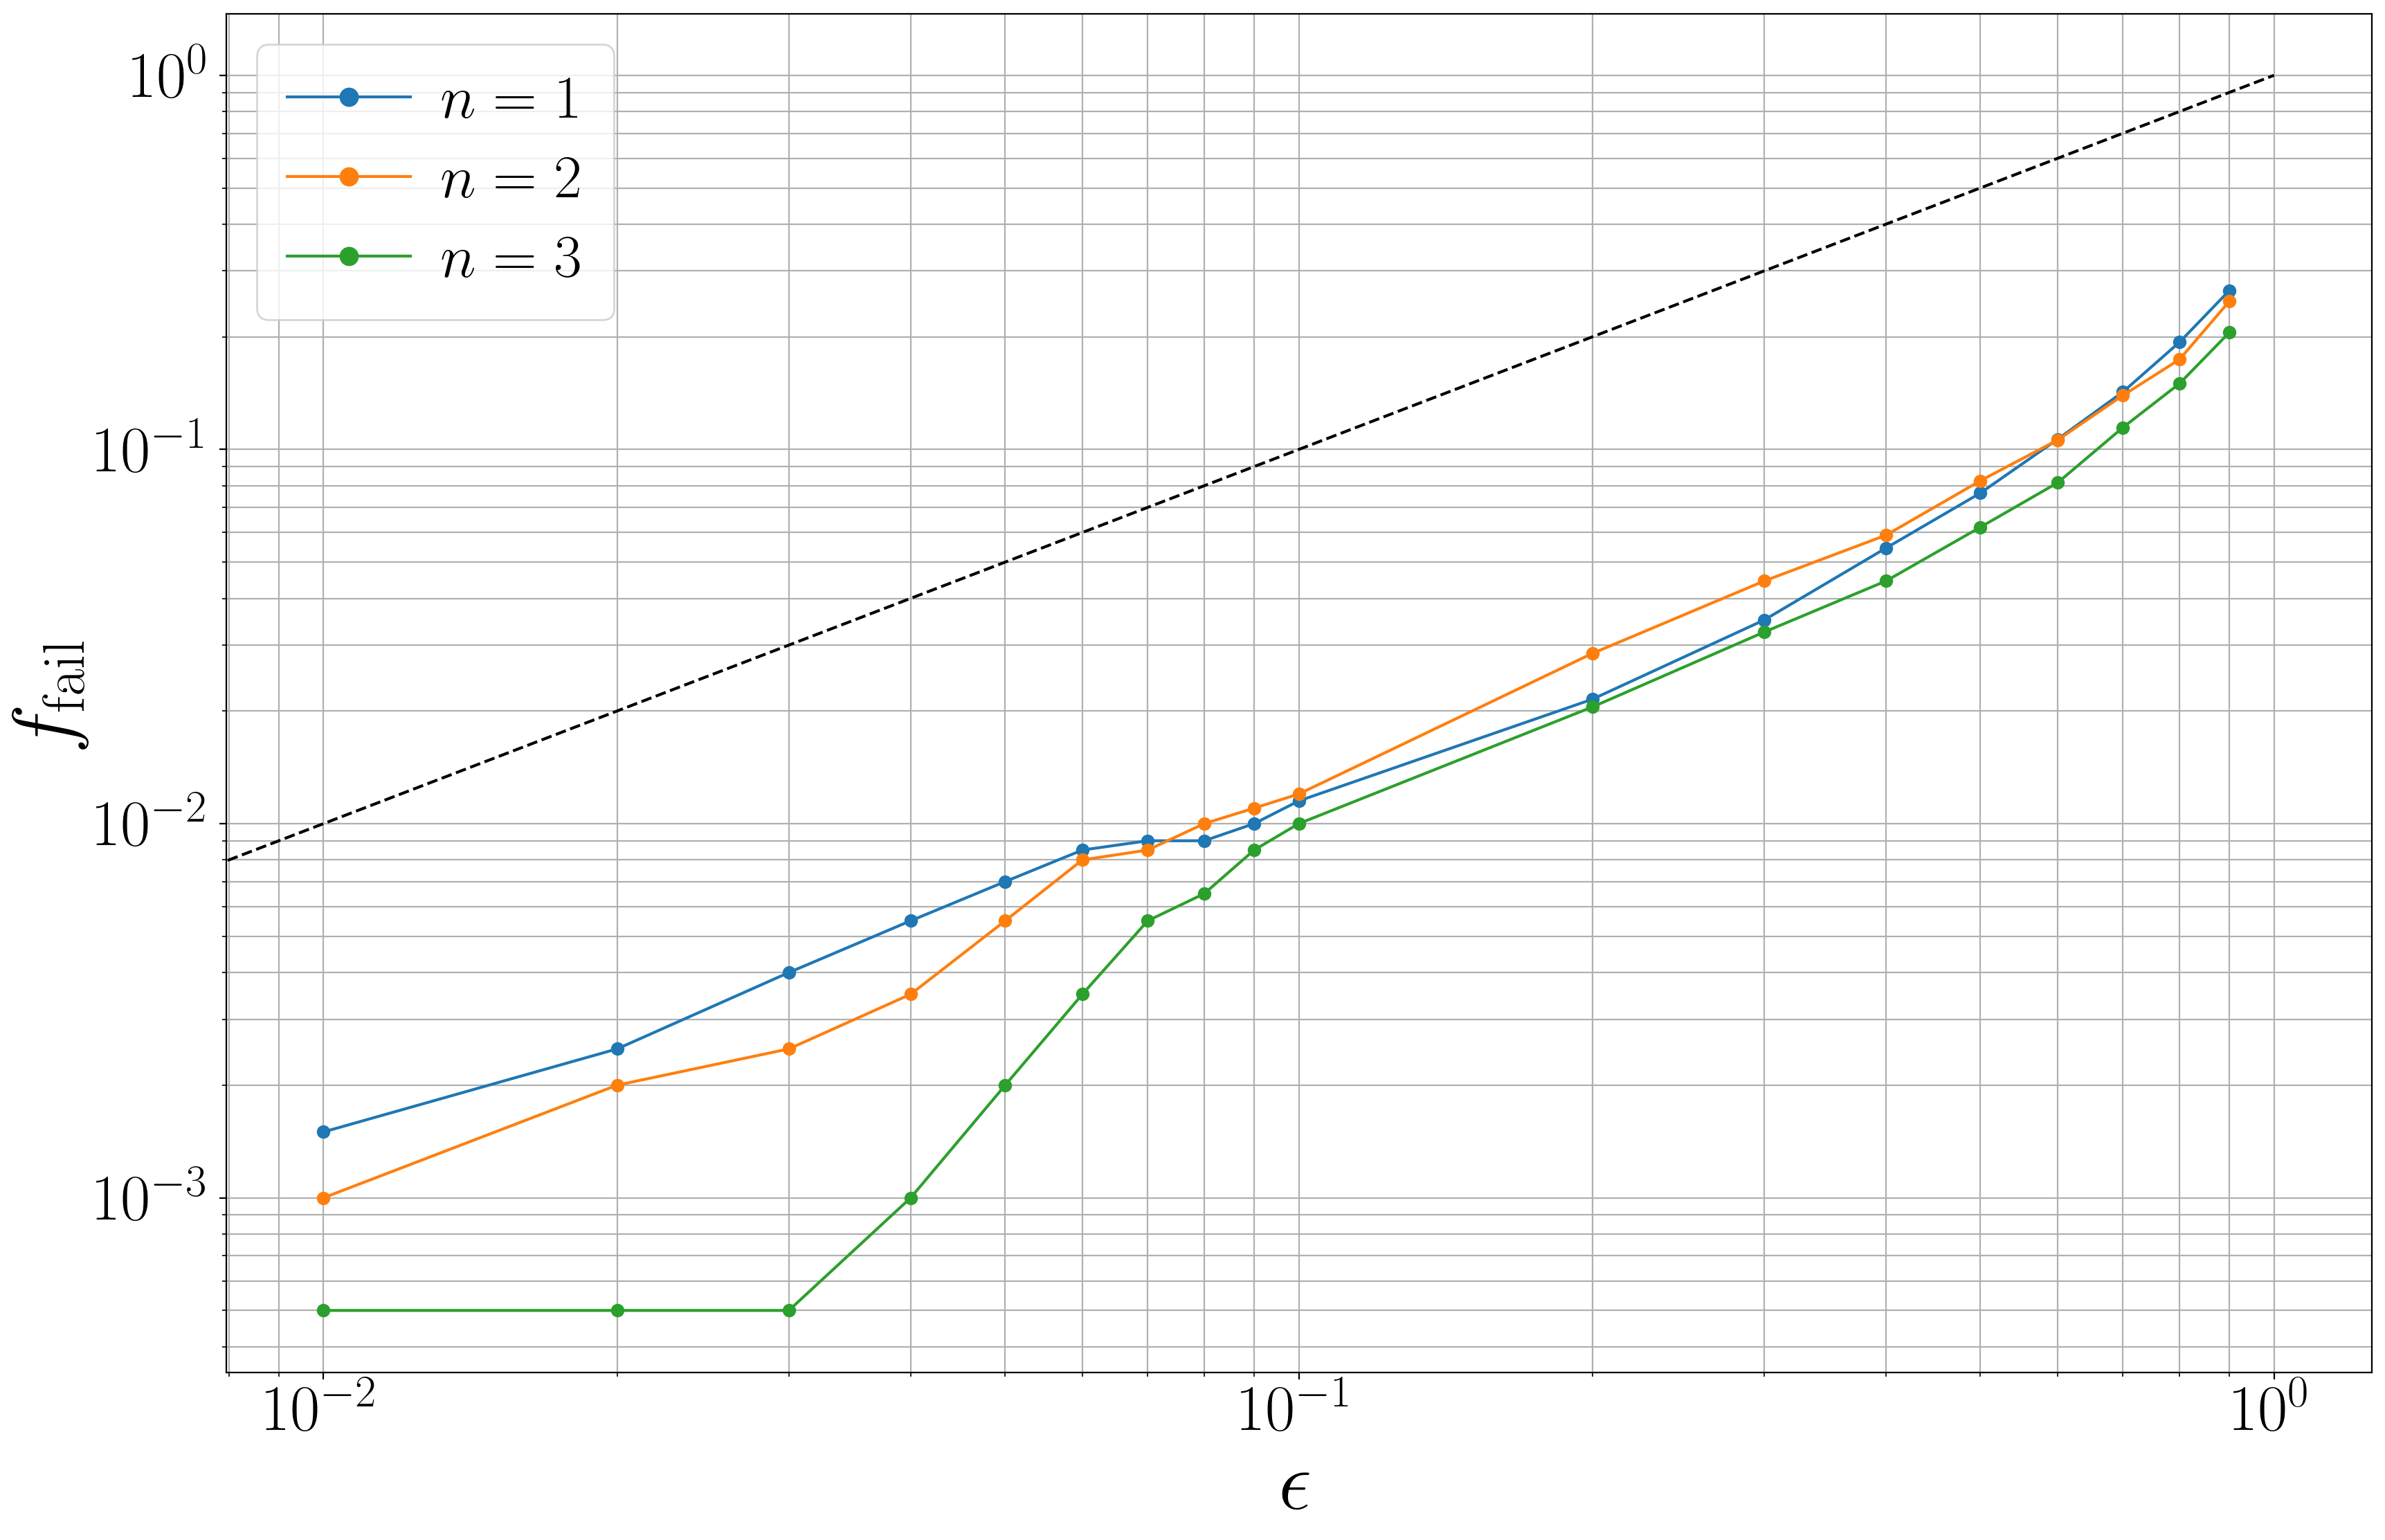

In [69]:
conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for n, results_for_qubit in enumerate(results):
    plt.plot(1 - conf_levels, 1 - results_for_qubit, '-o', label=f'$N={n+1}$')
plt.legend()
plt.savefig('../imgs/polytope/processes_qubits.png')

### f(epsilon) измерения процесс

In [4]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
conf_levels = np.arange(0.9, 1, 0.01)
n_meas_list = [int(n) for n in np.logspace(2, 7, 6)]
results = np.zeros((len(n_meas_list), len(conf_levels)))
n_trials = 10000
for i, n_measurements in enumerate(tqdm(n_meas_list)):
    channel = qp.channel.depolarizing(p=0.1, n_qubits=1)
    dim = 4 ** channel.n_qubits
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    EPS = 1e-15

    povm_matrix = tmg.tomographs[0].povm_matrix
    n_measurements = tmg.tomographs[0].n_measurements

    eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                              (-1, povm_matrix.shape[-1])) 
                   * povm_matrix.shape[0])
    Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
    pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
    pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                   pi_matrix.shape[2] * pi_matrix.shape[3]))
    A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
    polytope_prod = A @ channel.choi.bloch[dim:]
    
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        frequencies = np.asarray([
            np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
            for ptmg in tmg.tomographs
        ])
        for j, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.tomographs[0].n_measurements)
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                 - pi_matrix[:, 0] * 2 ** tmg.channel.n_qubits)
            if np.min(b - polytope_prod) > -EPS:
                results[i, j] += 1
results /= n_trials

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
with open('../results/polytope/processes_meas.pkl', 'rb') as file:
    obj = pickle.load(file)
results = obj['results']

In [7]:
results

array([[0.9912, 0.9921, 0.9948, 0.9958, 0.9962, 0.9966, 0.998 , 0.9988,
        0.9993, 0.9998],
       [0.9905, 0.991 , 0.993 , 0.9937, 0.995 , 0.9955, 0.9969, 0.9978,
        0.9988, 0.999 ],
       [0.9882, 0.9889, 0.9902, 0.992 , 0.9939, 0.995 , 0.9962, 0.9971,
        0.9976, 0.999 ],
       [0.9869, 0.9889, 0.99  , 0.991 , 0.9925, 0.9937, 0.9954, 0.9964,
        0.9976, 0.9995],
       [0.9891, 0.9897, 0.9908, 0.9922, 0.994 , 0.9952, 0.9959, 0.9971,
        0.998 , 0.9989],
       [0.9906, 0.9919, 0.9933, 0.9941, 0.9949, 0.9961, 0.9967, 0.9975,
        0.9986, 0.9995]])

In [9]:
new_results[:, -10:]

array([[0.9905, 0.9905, 0.9935, 0.9955, 0.9965, 0.9965, 0.999 , 0.999 ,
        0.9995, 1.    ],
       [0.9915, 0.9925, 0.994 , 0.995 , 0.9955, 0.996 , 0.9975, 0.998 ,
        0.9995, 0.9995],
       [0.9895, 0.9915, 0.9925, 0.994 , 0.994 , 0.9945, 0.995 , 0.997 ,
        0.9985, 0.9995],
       [0.989 , 0.99  , 0.9915, 0.9925, 0.9945, 0.9945, 0.997 , 0.9995,
        0.9995, 0.9995],
       [0.989 , 0.989 , 0.9895, 0.9915, 0.994 , 0.995 , 0.9965, 0.9975,
        0.9975, 0.9985],
       [0.9895, 0.9905, 0.9915, 0.993 , 0.9955, 0.9955, 0.9955, 0.9975,
        0.9985, 1.    ]])

In [12]:
new_results

array([[0.7425, 0.805 , 0.858 , 0.8955, 0.925 , 0.944 , 0.9575, 0.981 ,
        0.9912, 0.9921, 0.9948, 0.9958, 0.9962, 0.9966, 0.998 , 0.9988,
        0.9993, 0.9998],
       [0.719 , 0.797 , 0.845 , 0.8875, 0.9185, 0.9415, 0.959 , 0.976 ,
        0.9905, 0.991 , 0.993 , 0.9937, 0.995 , 0.9955, 0.9969, 0.9978,
        0.9988, 0.999 ],
       [0.731 , 0.8055, 0.8525, 0.8895, 0.921 , 0.94  , 0.9605, 0.9755,
        0.9882, 0.9889, 0.9902, 0.992 , 0.9939, 0.995 , 0.9962, 0.9971,
        0.9976, 0.999 ],
       [0.723 , 0.809 , 0.8625, 0.895 , 0.9185, 0.94  , 0.9615, 0.9745,
        0.9869, 0.9889, 0.99  , 0.991 , 0.9925, 0.9937, 0.9954, 0.9964,
        0.9976, 0.9995],
       [0.717 , 0.8035, 0.8525, 0.886 , 0.919 , 0.941 , 0.964 , 0.977 ,
        0.9891, 0.9897, 0.9908, 0.9922, 0.994 , 0.9952, 0.9959, 0.9971,
        0.998 , 0.9989],
       [0.7125, 0.7915, 0.845 , 0.8815, 0.9135, 0.937 , 0.958 , 0.976 ,
        0.9906, 0.9919, 0.9933, 0.9941, 0.9949, 0.9961, 0.9967, 0.9975,
        0.9

In [13]:
obj = {'cl': conf_levels, 'results': new_results}
with open('../results/polytope/processes_meas.pkl', 'wb') as file:
    pickle.dump(obj, file)

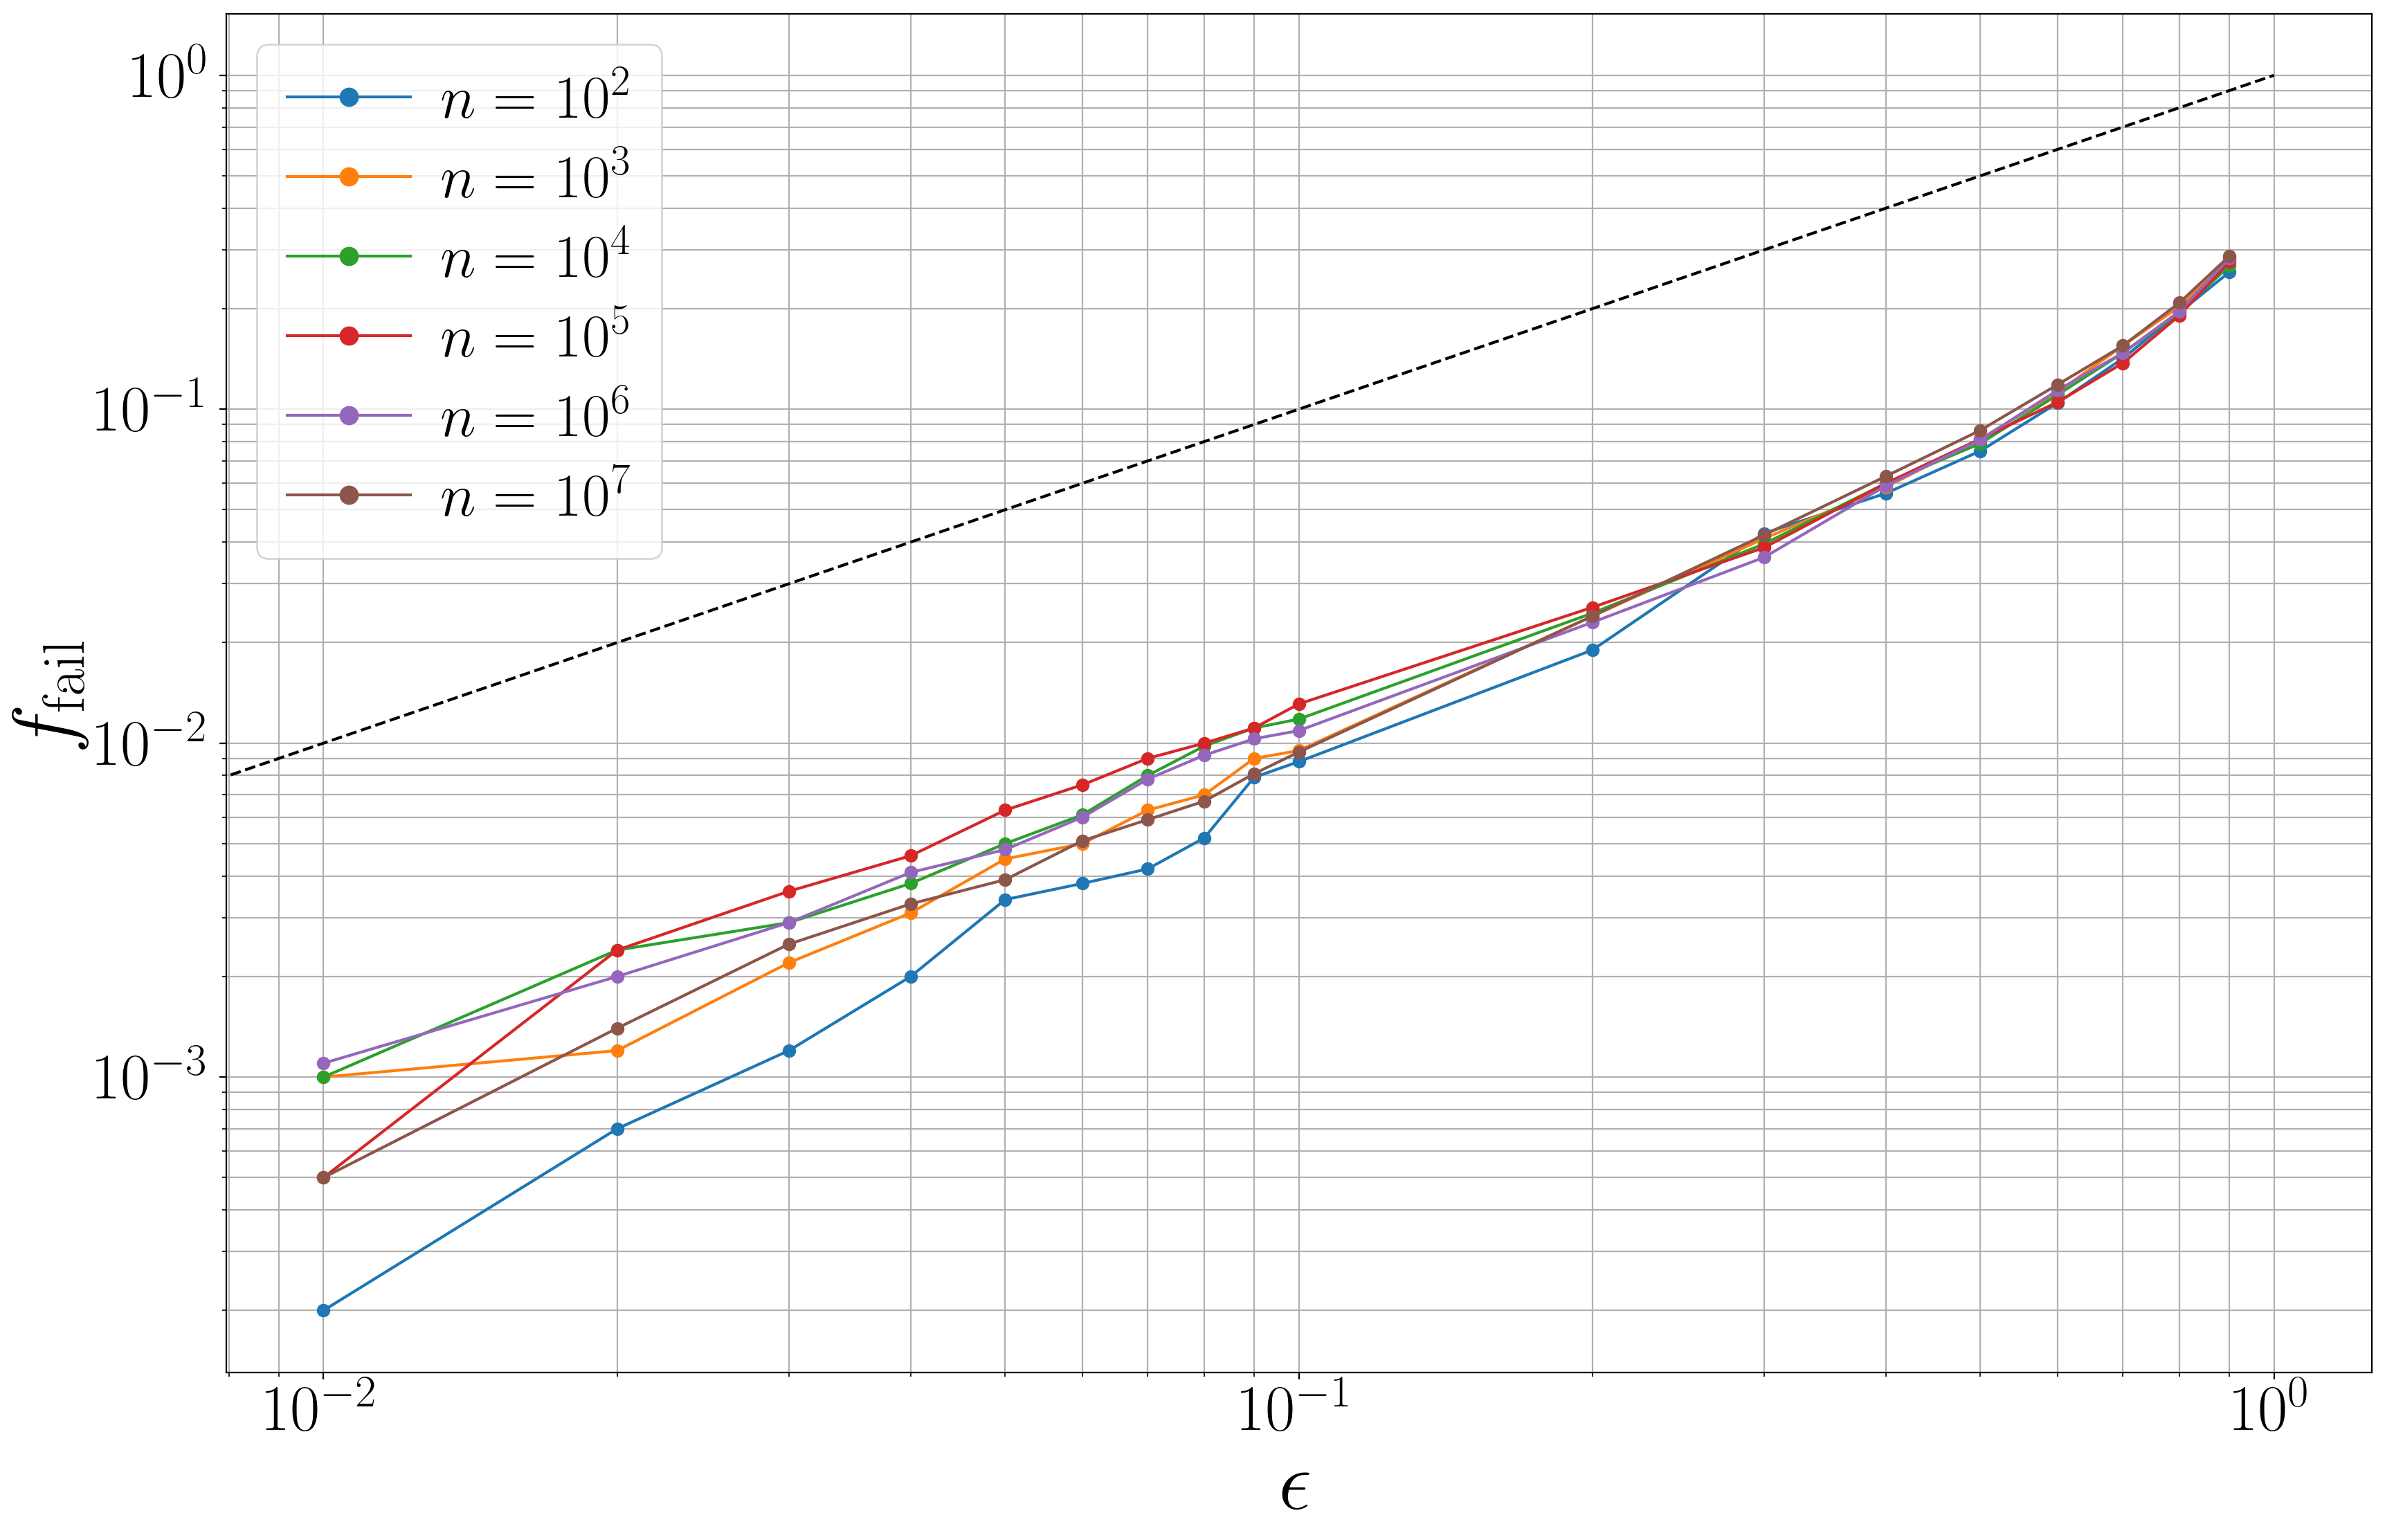

In [16]:
conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))

plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for n, row in enumerate(results):
    plt.plot(1 - conf_levels, 1 - row, '-o', label=f'$n=10^{n+2}$')
plt.legend()
plt.savefig('../imgs/polytope/processes_meas.png')

### shit

In [ ]:
conf_levels = [0.1, 0.25, 0.5, 0.75]
n_meas_list = [int(n) for n in np.logspace(2, 7, 10)]
freq_list_meas = defaultdict(list)
for n_measurements in n_meas_list:
    state = qp.qobj.GHZ(1)
    n_measurements = 10 ** i
    dim = 2 ** state.n_qubits
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements)
    state_hat = tmg.point_estimate()
    EPS = 1e-15

    povm_matrix = (np.reshape(tmg.povm_matrix * tmg.n_measurements[:, None, None]
                              / np.sum(tmg.n_measurements),
                              (-1, tmg.povm_matrix.shape[-1]))
                   * tmg.povm_matrix.shape[0])
    A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
    polytope_prod = A @ state.bloch[1:]

    n_trials = 2000
    conf_levels = [0.1, 0.25, 0.5, 0.75]
    results = np.zeros(len(conf_levels))
    for _ in tqdm(range(n_trials)):
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements)
        frequencies = np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
        for i, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.n_measurements)
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - povm_matrix[:, 0]
            if np.min(b - polytope_prod) > -EPS:
                results[i] += 1
    results /= n_trials
    for i, cl in enumerate(conf_levels):
        freq_list_meas[cl].append(results[i])

In [ ]:
conf_levels = [0.1, 0.25, 0.5, 0.75]
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Number of measurements')
plt.ylabel('Frequency')
plt.grid()
plt.xscale('log')
for cl in conf_levels:
    plt.scatter(n_meas_list, freq_list_meas[cl], label=f'CL={cl}')
plt.legend()

In [ ]:
conf_levels = [0.1, 0.25, 0.5, 0.75]
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Number of qubits')
plt.ylabel('Frequency')
plt.grid()
for cl in conf_levels:
    plt.scatter(n_qubits_list, freq_list_qubits[cl], label=f'CL={cl}')
plt.legend()

In [ ]:
idfr_meas

In [ ]:
idfr_qubits

In [ ]:
np.array(cl_qubits)

In [ ]:
plt.plot(conf_levels, results)
plt.plot([0, 1], [0, 1], '--k')

In [ ]:
def count_idfr(state, interval_cls, n_points=20, n_trials=500, n_measurements=10000):
    EPS = 1e-15
    results = np.zeros(n_points)
    for _ in tqdm(range(n_trials)):
        tmg = qp.StateTomograph(state)
        tmg.experiment(n_measurements)
        state_hat = tmg.point_estimate()
        dist_to_target = tmg.dst(state, state_hat)
        interval = interval_cls(tmg, n_points)
        radius_list, CL_list = interval()
        for i, (radius, cl) in enumerate(zip(radius_list, CL_list)):
            if radius > dist_to_target:
                results[i] += 1
    results /= n_trials
    idfr = np.sum((results - CL_list) * (CL_list[1] - CL_list[0]))
    return results, idfr

In [ ]:
def count_idfr_channel(channel, interval_cls, n_points=20, n_trials=500, n_measurements=10000):
    EPS = 1e-15
    results = np.zeros(n_points)
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        channel_hat = tmg.point_estimate()
        dist_to_target = tmg.dst(channel.choi, channel_hat.choi)
        interval = interval_cls(tmg, n_points)
        radius_list, CL_list = interval()
        for i, (radius, cl) in enumerate(zip(radius_list, CL_list)):
            if radius > dist_to_target:
                results[i] += 1
    results /= n_trials
    idfr = np.sum((results - CL_list) * (CL_list[1] - CL_list[0]))
    return results, idfr

In [ ]:
idfr_gamma = []
for i in range(1, 5):
    state = qp.qobj.GHZ(i)
    results, idfr = count_idfr(state, qp.MomentInterval, n_points=20, n_trials=500, n_measurements=100000)
    idfr_gamma.append(idfr)
idfr_gamma

In [ ]:
idfr_gamma_channel = []
for i in range(1, 5):
    channel = qp.channel.depolarizing(p=0.7, n_qubits=i)
    results, idfr = count_idfr_channel(channel, qp.MomentInterval, 
                                       n_points=20, n_trials=500, n_measurements=100000)
    idfr_gamma_channel.append(idfr)
idfr_gamma_channel

In [ ]:
idfr_gamma_channel

In [ ]:
idfr_wang = []
for i in range(1, 3):
    state = qp.qobj.GHZ(i)
    results, idfr = count_idfr(state, 
                               partial(qp.WangInterval, method='bbox'), 
                               n_points=20, n_trials=500, n_measurements=100000)
    idfr_wang.append(idfr)
idfr_wang

In [ ]:
for i in range(1, 3):
    state = qp.qobj.GHZ(i)
    results, idfr = count_idfr(state, 
                               partial(qp.WangInterval, method='bbox'), 
                               n_points=20, n_trials=500, n_measurements=100000)
    print(idfr)

In [ ]:
idfr_qubits_channel = []
cl_qubits_channel = []
for i in range(1, 4):
    channel = qp.channel.depolarizing(p=0.7, n_qubits=i)
    n_measurements = 100000
    dim = 4 ** channel.n_qubits
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    EPS = 1e-15

    povm_matrix = tmg.tomographs[0].povm_matrix
    n_measurements = tmg.tomographs[0].n_measurements

    eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                              (-1, povm_matrix.shape[-1])) 
                   * povm_matrix.shape[0])
    Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
    pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
    pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                   pi_matrix.shape[2] * pi_matrix.shape[3]))
    A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
    polytope_prod = A @ channel.choi.bloch[dim:]

    n_trials = 500
    step = 0.1
    conf_levels = np.arange(0.05, 1, step)
    results = np.zeros(len(conf_levels))
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        frequencies = np.asarray([
            np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
            for ptmg in tmg.tomographs
        ])
        for i, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.tomographs[0].n_measurements)
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                 - pi_matrix[:, 0] * 2 ** tmg.channel.n_qubits)
            if np.min(b - polytope_prod) > -EPS:
                results[i] += 1
    results /= n_trials
    idfr = np.sum((results - conf_levels) * step)
    idfr_qubits_channel.append(idfr)
    cl_qubits_channel.append(results)

In [ ]:
idfr_meas_channel = []
cl_meas_channel = []
for i in range(3, 7):
    channel = qp.channel.depolarizing(p=0.7, n_qubits=1)
    n_measurements = 10 ** i
    dim = 4 ** channel.n_qubits
    tmg = qp.ProcessTomograph(channel, input_states='sic')
    tmg.experiment(n_measurements)
    EPS = 1e-15

    povm_matrix = tmg.tomographs[0].povm_matrix
    n_measurements = tmg.tomographs[0].n_measurements

    eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                              (-1, povm_matrix.shape[-1])) 
                   * povm_matrix.shape[0])
    Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
    pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
    pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                   pi_matrix.shape[2] * pi_matrix.shape[3]))
    A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
    polytope_prod = A @ channel.choi.bloch[dim:]

    n_trials = 500
    step = 0.1
    conf_levels = np.arange(0.05, 1, step)
    results = np.zeros(len(conf_levels))
    for _ in tqdm(range(n_trials)):
        tmg = qp.ProcessTomograph(channel, input_states='sic')
        tmg.experiment(n_measurements)
        frequencies = np.asarray([
            np.clip(ptmg.raw_results / ptmg.n_measurements[:, None], EPS, 1 - EPS)
            for ptmg in tmg.tomographs
        ])
        for i, cl in enumerate(conf_levels):
            delta = WangInterval._count_delta(cl, frequencies, tmg.tomographs[0].n_measurements)
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                 - pi_matrix[:, 0] * 2 ** tmg.channel.n_qubits)
            if np.min(b - polytope_prod) > -EPS:
                results[i] += 1
    results /= n_trials
    idfr = np.sum((results - conf_levels) * step)
    idfr_meas_channel.append(idfr)
    cl_meas_channel.append(results)

In [ ]:
idfr_qubits_channel

In [ ]:
idfr_meas_channel

In [ ]:
cl_qubits_channel

In [ ]:
class ProcessWangInterval(qp.WangInterval):        
    def __call__(self):
        EPS = 1e-15
        dim = 4 ** self.tmg.channel.n_qubits
        bloch_dim = dim ** 2 - dim
        rho = self.tmg.point_estimate('lifp', cptp=False)
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
            for tmg in self.tmg.tomographs
        ])
        
        eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        Rt = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
        pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                       pi_matrix.shape[2] * pi_matrix.shape[3]))
        A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
        
        max_delta = self._count_delta(self.max_confidence, frequencies)
        
        if self.method == 'coarse':
            A_inv = _left_inv(A)
            prob_dim = povm_matrix.shape[0]
            coef1 = (np.linalg.norm(A_inv, ord=2)
                     * (self.tmg.povm_matrix.shape[1] - 1)
                     * np.sqrt(prob_dim))
            coef2 = np.linalg.norm(A_inv, ord=2) ** 2 * prob_dim
            max_dist = max(max_delta * coef1, np.sqrt(max_delta * coef2))
            dist_dummy = np.linspace(0, max_dist, self.n_points)
            deltas = np.maximum(dist_dummy / coef1, dist_dummy ** 2 / coef2)
        else:
            deltas = np.linspace(0, max_delta, self.n_points)
            dist_dummy = []
            for delta in deltas:
                b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                     - pi_matrix[:, 0] * 2 ** self.tmg.channel.n_qubits)
                if self.method == 'exact':
                    vertices = pypoman.compute_polytope_vertices(A, b)
                    vertex_states = [_make_feasible(qp.Qobj(vertex)) for vertex in vertices]
                    if vertices:
                        radius = max([self.tmg.dst(vertex_state, rho) for vertex_state in
                                      vertex_states])
                    else:
                        radius = 0
                elif self.method == 'bbox':
                    lb, ub = pc.Polytope(A, b).bounding_box
                    volume = np.prod(ub - lb)
                    radius = ((volume * math.gamma(bloch_dim / 2 + 1)) ** (1 / bloch_dim)
                              / math.sqrt(math.pi))
                elif self.method == 'approx':
                    volume = compute_polytope_volume(pc.Polytope(A, b))
                    radius = ((volume * math.gamma(bloch_dim / 2 + 1)) ** (1 / bloch_dim)
                              / math.sqrt(math.pi))
                elif self.method == 'hit_and_run':
                    rho_bloch = rho.bloch[1:]
                    radius = find_max_distance_to_polytope(A, b, rho_bloch, rho_bloch)
                else:
                    raise ValueError("Invalid value for argument `mode`.")
                dist_dummy.append(radius)

        CLs_dummy = []
        for delta in deltas:
            CLs_dummy.append(self._count_confidence(delta, frequencies))
        cl_to_dist = interp1d(CLs_dummy, dist_dummy)
        CLs = np.linspace(0, self.max_confidence, self.n_points)
        dist = cl_to_dist(CLs)
        return dist, CLs
        
    def _count_confidence(self, delta, frequencies):
        EPS = 1e-15
        freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
        KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                         + (1 - frequencies) * np.log(
                    (1 - frequencies) / (1 - freq_plus_delta)))
        KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
        epsilons = np.exp(-self.tmg.tomographs[0].n_measurements[:, None] * KL_divergence)
        epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
        return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))

In [ ]:
channel = qp.operator.Id.as_channel()
dim = 4 ** channel.n_qubits
tmg = qp.ProcessTomograph(channel, input_states='sic')
# tmg.input_basis.elements[1] = tmg.input_basis.elements[1].T
tmg.experiment(100000, povm='proj-set')
interval = ProcessWangInterval(tmg)
dist, CL = interval()
# eta_matrix, A, b = interval()

# R = np.asarray([channel.transform(rho).bloch for rho in tmg.input_basis.elements])
# probs = R @ eta_matrix.T * dim

# np.allclose(np.reshape(A @ channel.choi.bloch[dim**2:] + b, probs.shape), probs)

In [ ]:
dim/(dim)

In [ ]:
dist

In [ ]:
delta = 0.05
EPS = 1e-15
A = dim * np.ascontiguousarray(pi_matrix[:, dim:])
b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
     - pi_matrix[:, 0] * 2 ** channel.n_qubits)

In [ ]:
b - A @ channel.choi.bloch[dim:]

In [ ]:
for i in range(dim**2-dim):
    x = channel.choi.bloch[dim:].copy()
    x[i] += 100
    print(i, np.min(b - A @ x))
    

In [ ]:
b - A @ x

In [ ]:
(m, n) = A.shape
idn = np.eye(n)
l = np.zeros(n)
u = np.zeros(n)
# lower corner
for i in range(n):
    sol = linprog(idn[i], A, b)
    x = sol.x
    print(sol.success, x)
    l[i] = x[i]
# upper corner
for i in range(n):
    sol = linprog(-idn[i], A, b)
    x = sol.x
    print(sol.success)
    u[i] = x[i]

In [ ]:
np.linalg.matrix_rank(A)

In [ ]:
sol = linprog(idn[4], A, b)

In [ ]:
qp.routines._left_inv(A).shape

In [ ]:
qp.routines._left_inv(A) @ np.reshape(frequencies, (-1, 1)) - channel.choi.bloch[dim:]

In [ ]:
b - A @ channel.choi.bloch[dim:]

In [ ]:
channel.choi.bloch[dim:]

In [ ]:
A.shape

In [ ]:
A

In [ ]:
A.shape

In [ ]:
l, u

In [ ]:
i = 4
sol = linprog(-idn[i], A, b, callback=lambda sol: print(sol.slack))
x = sol['x']
x[i]

In [ ]:
pol = pc.Polytope(A, b)
print(pc.Polytope(A, b).bounding_box)
lb, ub = pc.Polytope(A, b).bounding_box
volume = np.prod(ub - lb)
print(volume)

In [ ]:
A.shape

In [ ]:
b - A @ channel.choi.bloch[dim:]

In [ ]:
A @ channel.choi.bloch[dim:] + pi_matrix[:, 0] * 2 ** channel.n_qubits

In [ ]:
np.hstack(np.concatenate(frequencies, axis=0))

In [ ]:
channel.choi.bloch[dim:] - lb.reshape(1, -1)

In [ ]:
channel.choi.bloch[dim:] in pol

In [ ]:
np.linalg.solve(A, b)

In [ ]:
A.shape

In [ ]:
b.shape

In [ ]:
(A @ channel.choi.bloch[dim:] + pi_matrix[:, 0] * 2 ** channel.n_qubits).reshape(4, 3, 2)

In [ ]:
frequencies

In [ ]:
np.hstack(np.concatenate(freq, axis=0)).reshape(4, 6)

In [ ]:
(pi @ channel.choi.bloch).reshape(4, 6) * 4

In [ ]:
interval

In [ ]:
probs.shape

In [ ]:
np.allclose(np.reshape(A @ channel.choi.bloch[dim**2:] * dim ** 2 + b * dim, probs.shape), probs)

In [ ]:
pi_matrix.shape

In [ ]:
tmg.tomographs[0].raw_results

In [ ]:
R = np.asarray([channel.transform(rho).bloch for rho in tmg.input_basis.elements])
Rt = np.asarray([rho.T.bloch for rho in tmg.input_basis.elements])
Rt

In [ ]:
R @ povm_matrix.T * 2

In [ ]:
pi = np.einsum("ij,ab->iajb", Rt, povm_matrix)
pi = pi.reshape((pi.shape[0] * pi.shape[1], pi.shape[2] * pi.shape[3]))
(pi @ channel.choi.bloch).reshape(4, 6) * 4

In [ ]:
pi = np.asarray([qp.kron(rho.T, qp.Qobj(povm_effect)).bloch 
                 for rho, povm_effect in it.product(tmg.input_basis.elements, povm_matrix)])
pi.shape

In [ ]:
def find_max_distance_to_polytope(A, b, target_point_bloch, start_point_bloch, n_points=10000,
                                  discard_closer=False, hit_and_run=True):
    """Compute the distance between the target point and the farthest point in the polytope
    using hit and run algorithm.

    Parameters
    ----------
    polytope : polytope.Polytope
    """
    dim = A.shape[1]
    max_dist = la.norm(start_point_bloch - target_point_bloch)
    
    directions = []

    for _ in range(n_points):
        direction = np.random.rand(dim) * 2 - 1

        # discard directions pointing towards the target point
        while (discard_closer and
               np.dot(direction, start_point_bloch - target_point_bloch) <= 0):
            direction = np.random.rand(dim) * 2 - 1
        direction /= la.norm(direction)

        farthest_point_bloch = find_farthest_polytope_point(A, b, start_point_bloch, direction)
        if hit_and_run:
            theta = random.random()
            start_point_bloch = theta * start_point_bloch + (1 - theta) * farthest_point_bloch
            max_dist = max(max_dist, la.norm(start_point_bloch - target_point_bloch))
        else:
            max_dist = max(max_dist, la.norm(farthest_point_bloch - target_point_bloch))
        directions.append(direction)
    return max_dist * np.sqrt(np.sqrt(dim) / 2)


def find_farthest_polytope_point(A, b, start_point, direction, tol=1e-15, init_alpha=1):
    step = alpha = init_alpha

    while True:
        cur_point = start_point + alpha * direction
        diff = np.min(b - A @ cur_point)
#         print(diff, alpha, step)
        if -tol <= diff < tol:
            break
        elif diff < -tol:
            step /= 2
            alpha -= step
        else:
            step *= 2
            alpha += step

    return cur_point

In [ ]:
state = qp.Qobj([1, 0], is_ket=True)
state = qp.channel.depolarizing(0.1).transform(state)
tmg = qp.StateTomograph(state)
tmg.experiment(1000, POVM='proj-set')
state_hat = tmg.point_estimate(physical=False)

dim = 2 ** tmg.state.n_qubits
EPS = 1e-15
frequencies = np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)

POVM_matrix = np.reshape(
    tmg.POVM_matrix * tmg.n_measurements[:, None, None] / np.sum(tmg.n_measurements),
    (-1, tmg.POVM_matrix.shape[-1])) * dim * tmg.POVM_matrix.shape[0]

delta = 0
A = np.ascontiguousarray(POVM_matrix[:, 1:])
b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - POVM_matrix[:, 0] / dim
polytope = pc.Polytope(A, b)
# vertices = pypoman.compute_polytope_vertices(A, b)
# vertex_states = [qp.Qobj(vertex) for vertex in vertices]
# max_dist_true = max([tmg.dst(vertex_state, state) for vertex_state in vertex_states])
# farthest_vertex = vertices[np.argmax([tmg.dst(vertex_state, state) for vertex_state in vertex_states])]
# true_direction = farthest_vertex - state.bloch[1:]
# true_direction /= la.norm(true_direction)
# print(max_dist_true)

In [ ]:
channel = 0.9 * qp.operator.H.as_channel() + 0.1 * qp.channel.depolarizing(0.1)
tmg = qp.ProcessTomograph(channel)
tmg.experiment(1000, POVM='proj-set')
channel_hat = tmg.point_estimate('lifp')

In [ ]:
# dist, CL = tmg.gamma_interval(1000, 'wang', wang_mode='bbox')
intervals = [
    qp.GammaInterval(tmg, 1000),
    qp.WangInterval(tmg, 1000),
    qp.SugiyamaInterval(tmg, 1000),
    qp.BootstrapStateInterval(tmg, 1000),
    qp.MHMCStateInterval(tmg, 1000),
]
res = []
for interval in intervals:
    res.append(interval())

In [ ]:
intervals = [
    qp.GammaInterval(tmg, 1000),
    qp.HolderInterval(tmg, 1000, 'gamma'),
    qp.HolderInterval(tmg, 1000, 'wang'),
    qp.HolderInterval(tmg, 1000, 'sugiyama'),
    qp.HolderInterval(tmg, 1000, 'mhmc'),
    qp.HolderInterval(tmg, 1000, 'bootstrap'),
    qp.BootstrapProcessInterval(tmg, 1000),
    qp.MHMCProcessInterval(tmg, 1000),
]
res = []
for interval in tqdm(intervals):
    res.append(interval())

In [ ]:
plt.figure(figsize=(20, 12), dpi=200)
plt.grid()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 0.2)
for i, result in enumerate(res):
    plt.plot(result[0], result[1], label=i)
    plt.legend()

In [ ]:
# plt.plot(dist_new, CL_new)
plt.plot(dist, CL)

In [ ]:
(np.asarray(dist_new) - np.asarray(dist)).sum(), (CL_new - CL).sum()

In [ ]:
np.hstack(frequencies)

In [ ]:
POVM_matrix @ state_hat.bloch

In [ ]:
np.hstack(frequencies) - POVM_matrix @ state_hat.bloch - (b - A @ state_hat.bloch[1:])

In [ ]:
b - A @ state_hat.bloch[1:]

In [ ]:
state_hat.bloch[1:]

In [ ]:
max_dist_ff = qp.polytope.find_max_distance_to_polytope(
    A, b -0.001, state.bloch[1:], state_hat.bloch[1:], discard_closer=True, hit_and_run=True, n_points=100)
max_dist_ff

In [ ]:
n_points_list = np.logspace(0.5, 3.5, 50)
dist = []
for n_points in tqdm(n_points_list):
    max_dist = qp.polytope.find_max_distance_to_polytope(
        A, b, state.bloch[1:], state_hat.bloch[1:], discard_closer=True, 
        hit_and_run=True, n_points=int(n_points)
    )
    dist.append(max_dist)

In [ ]:
n_points_list = np.logspace(0.5, 3.5, 50)
dist_center = []
for n_points in tqdm(n_points_list):
    max_dist = qp.polytope.find_max_distance_to_polytope(
        A, b, state.bloch[1:], state_hat.bloch[1:], discard_closer=True, 
        hit_and_run=False, n_points=int(n_points)
    )
    dist_center.append(max_dist)

In [ ]:
n_points_list[np.where(np.asarray(dist) > 0.034)[0][0]]

In [ ]:
plt.figure(figsize=(20, 13), dpi=200)
plt.grid()
plt.xlabel('Number of points')
plt.ylabel('HS distance')
plt.plot(n_points_list, dist, label='Hit and run')
plt.plot(n_points_list, dist_center, label='Random direction')
plt.plot([0, 10 ** 3.5], [max_dist_true] * 2, label='True distance')
plt.legend()
plt.title('$|00\\rangle$')
plt.savefig('../../results/polytope_radius/zero2_new.png')

In [ ]:
print(np.dot(closest_direction, true_direction))

In [ ]:
farthest_vertex_true = find_farthest_polytope_point(A, b, state.bloch[1:], true_direction, 
                                                   tol=1e-15, init_alpha=1)
farthest_vertex_close = find_farthest_polytope_point(A, b, state.bloch[1:], closest_direction, 
                                                    tol=1e-15, init_alpha=1)
print(np.dot(closest_direction, true_direction))

In [ ]:
max_dist_ff, directions = find_max_distance_to_polytope(
    A, b, state.bloch[1:], state_hat.bloch[1:], discard_closer=True, hit_and_run=False, n_points=1000)
max_dist_ff

In [ ]:
sim = np.argsort([np.dot(direction, true_direction) for direction in directions])
closest_direction = directions[sim[-1]]

In [ ]:
directions[sim[-1]]

## Renner intervals

In [ ]:
def plot_renner_intervals(state, n_measurements=1000, POVM='proj-set'):
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements, POVM)

    t0 = time.time()
    dist_coarse, CL_coarse = tmg.wang_interval(1000, 'coarse')
    t1 = time.time()
    dist_exact, CL_exact = tmg.wang_interval(1000, 'exact')
    t2 = time.time()
    dist_bbox, CL_bbox = tmg.wang_interval(1000, 'bbox')
    t3 = time.time()
    dist_approx, CL_approx = tmg.wang_interval(1000, 'hit_and_run')
    t4 = time.time()

    dist_true = []
    for _ in range(1000):
        tmg.experiment(n_measurements, POVM)
        state_hat = tmg.point_estimate('lin')
        dist_true.append(qp.hs_dst(state_hat, state))
    dist_true = sorted(dist_true)
    CL_true = np.linspace(0, 1, 1000)

    print(f'Coarse: {t1 - t0} s')
    print(f'Exact: {t2 - t1} s')
    print(f'Bbox: {t3 - t2} s')
    print(f'Approx: {t4 - t3} s')
    
    x_max = max([
        dist_approx[np.asarray(CL_approx > 0.99).nonzero()[0][0]],
        dist_exact[np.asarray(CL_exact > 0.99).nonzero()[0][0]],
        dist_bbox[np.asarray(CL_bbox > 0.99).nonzero()[0][0]],
        dist_true[np.asarray(CL_true > 0.99).nonzero()[0][0]],
    ])
    
    x_min = min([
        dist_approx[np.asarray(CL_approx > -0.5).nonzero()[0][0]],
        dist_exact[np.asarray(CL_exact > -0.5).nonzero()[0][0]],
        dist_bbox[np.asarray(CL_bbox > -0.5).nonzero()[0][0]],
        dist_true[np.asarray(CL_true > -0.5).nonzero()[0][0]],
    ])

    plt.figure(figsize=(20, 12), dpi=200)
    plt.xlabel('$\\delta$')
    plt.ylabel('$\\epsilon$')
    plt.grid()
    plt.ylim((-0.05, 1.05))
    plt.xlim(left=x_min, right=x_max)
    # plt.plot(dist_coarse, CL_coarse, 'k', label='Coarse', linestyle='--')
    plt.plot(dist_exact, CL_exact, 'k', label='Exact', linestyle='-')
    plt.plot(dist_bbox, CL_bbox, 'k', label='Bbox', linestyle='-.')
    plt.plot(dist_approx, CL_approx, 'k', label='Hit and run', linestyle=':')
    plt.plot(dist_true, CL_true, 'k', label='True', linestyle='--')
    plt.legend()
    plt.show()

In [ ]:
state = qp.Qobj([1, 0], is_ket=True)
plot_renner_intervals(state, 1000, POVM='proj-set')

In [ ]:
channel = qp.operator.H.as_channel()

tmg = qp.ProcessTomograph(channel)
tmg.experiment(10000)
channel_hat = tmg.point_estimate(cptp=False)
dist_lifp, CL_lifp = tmg.gamma_interval(1000, 'lifp')
dist_bloch, CL_bloch = tmg.gamma_interval(1000, 'bloch')